In [13]:
# ============================================
# Fase 3B — Regressione lineare tra titoli tech
# Obiettivo: spiegare i rendimenti di un titolo (Y) con quelli degli altri (X)
# ============================================

# --- Import base ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelli e metriche
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

# Per VIF (multicollinearità)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  # solo per residui opzionali

# --- Percorsi ---
PROC_DIR = "data/processed"
RET_PATH  = os.path.join(PROC_DIR, "return_daily.csv")


returns = pd.read_csv(RET_PATH, index_col=0, parse_dates=True).sort_index()
returns.head()


,AAPL,AMZN,GOOG,MSFT,NVDA
Date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.000174,0.012694,0.016280,0.004643,0.063739
2018-01-04,0.004634,0.004466,0.003615,0.008763,0.005258
2018-01-05,0.011321,0.016033,0.014466,0.012322,0.008438
2018-01-08,-0.003721,0.014322,0.004264,0.001020,0.030181


In [14]:
# scelte di modellizzazione
Y_TICKER = "NVDA"                     
X_TICKERS = ["AAPL", "MSFT", "AMZN", "GOOG"]  

# --- Preparazione X, y ---
y = returns[Y_TICKER].copy()
X = returns[X_TICKERS].copy()

# Allineiamo e rimuoviamo righe con NaN su X o y
df = pd.concat([y, X], axis=1).dropna()
y = df[Y_TICKER]
X = df[X_TICKERS]

print("Date range:", df.index.min().date(), "→", df.index.max().date())
print("Osservazioni:", len(df))


Date range: 2018-01-03 → 2025-08-12
Osservazioni: 1912


In [15]:
# --- Train/Test split temporale ---
SPLIT_DATE = "2024-01-01"

X_train = X.loc[:SPLIT_DATE].iloc[:-1]   # fino al giorno prima dello split
y_train = y.loc[:SPLIT_DATE].iloc[:-1]
X_test  = X.loc[SPLIT_DATE:]             # dal giorno di split in poi
y_test  = y.loc[SPLIT_DATE:]

print("Train:", X_train.index.min().date(), "→", X_train.index.max().date(), "| n =", len(X_train))
print("Test: ", X_test.index.min().date(),  "→", X_test.index.max().date(),  "| n =", len(X_test))


Train: 2018-01-03 → 2023-12-28 | n = 1507
Test:  2024-01-02 → 2025-08-12 | n = 404


In [16]:
# --- Standardizzazione ---
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("linreg", LinearRegression(fit_intercept=True))
])

# Fit sul train
pipe.fit(X_train, y_train)

# Predizioni
y_pred_train = pipe.predict(X_train)
y_pred_test  = pipe.predict(X_test)

# Metriche
r2_tr  = r2_score(y_train, y_pred_train)
r2_te  = r2_score(y_test,  y_pred_test)
mae_tr = mean_absolute_error(y_train, y_pred_train)
mae_te = mean_absolute_error(y_test,  y_pred_test)

print(f"R^2 train: {r2_tr:.3f} | MAE train: {mae_tr:.5f}")
print(f"R^2 test : {r2_te:.3f} | MAE test : {mae_te:.5f}")


R^2 train: 0.545 | MAE train: 0.01542
R^2 test : 0.334 | MAE test : 0.01993


In [17]:
# --- Coefficienti del modello (su dati standardizzati) ---
coefs = pipe.named_steps["linreg"].coef_
coef_series = pd.Series(coefs, index=X.columns).sort_values(ascending=False)
coef_series


MSFT    0.010682
AAPL    0.006454
AMZN    0.005514
GOOG    0.004193
dtype: float64

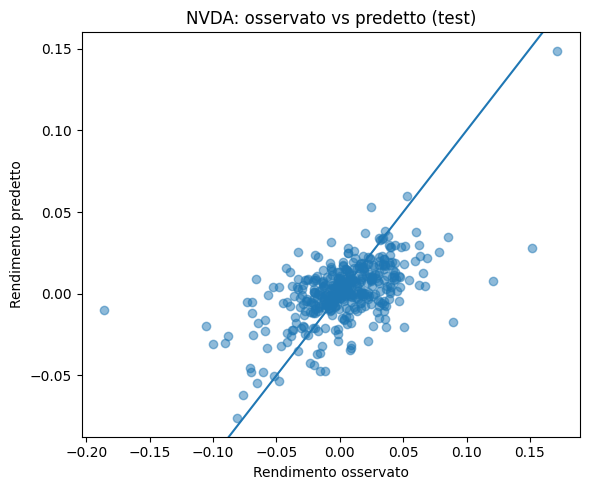

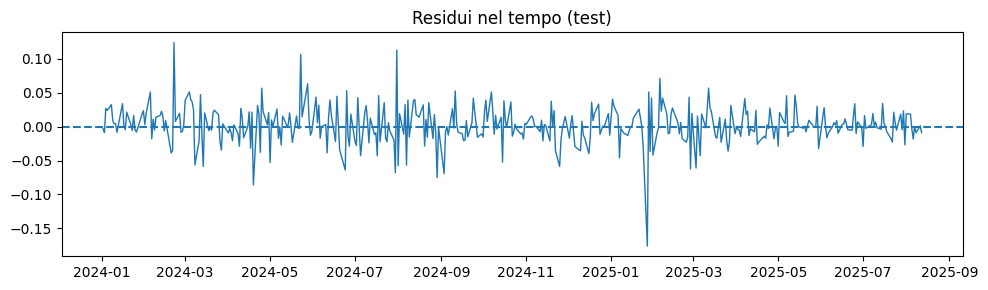

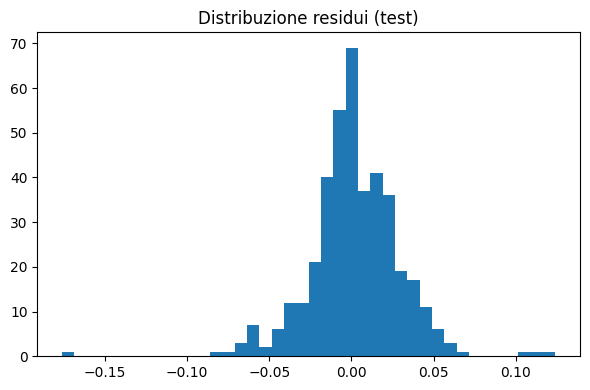

In [18]:
# --- Diagnostica visiva: y vs y_hat e residui ---
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.axline((0,0), slope=1)
plt.title(f"{Y_TICKER}: osservato vs predetto (test)")
plt.xlabel("Rendimento osservato")
plt.ylabel("Rendimento predetto")
plt.tight_layout()
plt.show()

resid_test = y_test - y_pred_test

plt.figure(figsize=(10,3))
plt.plot(resid_test.index, resid_test, lw=1)
plt.axhline(0, linestyle="--")
plt.title("Residui nel tempo (test)")
plt.tight_layout()
plt.show()

# (Facoltativo) Istogramma residui
plt.figure(figsize=(6,4))
plt.hist(resid_test.dropna(), bins=40)
plt.title("Distribuzione residui (test)")
plt.tight_layout()
plt.show()


In [21]:
# --- Multicollinearità: correlazioni e VIF ---
corr = X_train.corr()
print("Correlazione predittori (train):")
display(corr)

# VIF richiede una matrice senza NA e come numpy array
X_train_np = X_train.values
vif = pd.Series(
    [variance_inflation_factor(X_train_np, i) for i in range(X_train_np.shape[1])],
    index=X_train.columns,
    name="VIF"
).sort_values(ascending=False)
vif


Correlazione predittori (train):


,AAPL,MSFT,AMZN,GOOG
AAPL,1.000000,0.751744,0.625188,0.676358
MSFT,0.751744,1.000000,0.697928,0.765223
AMZN,0.625188,0.697928,1.000000,0.677447
GOOG,0.676358,0.765223,0.677447,1.000000


MSFT    3.457666
GOOG    2.768615
AAPL    2.499564
AMZN    2.209776
Name: VIF, dtype: float64

In [19]:

# Esempio: rimuovo il predittore più collineare (sostituisci 'AAPL' con quello che vuoi testare)
DROP = None  # es. "AAPL"
if DROP is not None:
    X_train_red = X_train.drop(columns=[DROP])
    X_test_red  = X_test.drop(columns=[DROP])

    pipe_red = Pipeline([("scaler", StandardScaler()), ("linreg", LinearRegression())])
    pipe_red.fit(X_train_red, y_train)

    y_pred_te_red = pipe_red.predict(X_test_red)
    print(f"R^2 test (senza {DROP}): {r2_score(y_test, y_pred_te_red):.3f}")


In [20]:
# --- Export sintetico dei risultati ---
out_text = os.path.join(PROC_DIR, f"regression_summary_{Y_TICKER}.txt")
with open(out_text, "w") as f:
    f.write(f"Target (Y): {Y_TICKER}\n")
    f.write(f"Predictors (X): {', '.join(X_TICKERS)}\n")
    f.write(f"Split date: {SPLIT_DATE}\n")
    f.write(f"R2 train: {r2_tr:.4f} | MAE train: {mae_tr:.6f}\n")
    f.write(f"R2 test : {r2_te:.4f} | MAE test : {mae_te:.6f}\n")
    f.write("\nCoefficients (standardized):\n")
    for k, v in coef_series.items():
        f.write(f"  {k}: {v:.4f}\n")
    f.write("\nCorrelations among predictors (train):\n")
    f.write(corr.to_string())
    f.write("\n\nVIF:\n")
    f.write(vif.to_string())

print("Salvato:", out_text)


Salvato: data/processed\regression_summary_NVDA.txt
